In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import itertools
import time

In [2]:
def stworz_wektor_pojazdy(n, ust_pojazd):
    wynik = np.random.choice(np.arange(1, ust_pojazd + 1), size = n)
    wektor_pojazdy = []
    for i in range(0, ust_pojazd):
        pom = (np.array(np.where(wynik == i+1)) + 1).flatten()
        wektor_pojazdy.append(pom)
    return wektor_pojazdy

In [3]:
def potasuj(wektor_pojazdy, ust_pojazd):
    for i in range(0, ust_pojazd):
        np.random.shuffle(wektor_pojazdy[i])
    return wektor_pojazdy

In [4]:
def losuj_liczbe_bez_srodka(n, x):
    # n - ile ciezarowek
    # x - z ktorej ciezarowki wybrany do swapowania
    # return ciezarowke do ktorej trafia swapowany
    liczba = x
    while liczba == x:
        liczba = np.random.choice(np.arange(0, n), size = 1)[0]  
    return liczba

In [5]:
def swap(wektor_pojazdy, klienci):
    kopia = deepcopy(wektor_pojazdy)
    
    if len(wektor_pojazdy) == 1:
        return kopia # gdyby byla tylko jedna ciezarowka, to nie ma co swapowac
    
    podmiana = np.random.choice(np.arange(1, len(klienci) + 1), size = 1)[0]  
    for i in range(0, len(wektor_pojazdy)):
        if podmiana in wektor_pojazdy[i]:
            kopia[i] = wektor_pojazdy[i][wektor_pojazdy[i] != podmiana]
            pom = i
            break
    wylosowana = losuj_liczbe_bez_srodka(len(wektor_pojazdy), pom)
    kopia[wylosowana] = np.append(wektor_pojazdy[wylosowana], podmiana)
    return kopia

In [6]:
def reorder(wektor_pojazdy):
    kopia = deepcopy(wektor_pojazdy)
    ciezarowa_do_zmiany = np.random.choice(len(wektor_pojazdy), size=1)[0]
    
    temp_id = 0
    while len(wektor_pojazdy[ciezarowa_do_zmiany]) < 2:
        ciezarowa_do_zmiany = np.random.choice(len(wektor_pojazdy), size=1)[0]
        temp_id += 1
        if temp_id > 40:
            return kopia # gdy nie da rady wybrac takich, ktore maja po 2 dlugosci

    idx_change = np.random.choice(len(wektor_pojazdy[ciezarowa_do_zmiany]), size=2, replace=False)

    temp = kopia[ciezarowa_do_zmiany][idx_change[0]]
    kopia[ciezarowa_do_zmiany][idx_change[0]] = wektor_pojazdy[ciezarowa_do_zmiany][idx_change[1]]
    kopia[ciezarowa_do_zmiany][idx_change[1]] = temp
    return kopia

In [7]:
def euclidean_dist(point1, point2):
    # point1, 2 są array dwuelementowymi (x,y)
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def odleglosci(coord_bazy, coord_klientow):
    liczba_klientow = len(coord_klientow)
    # coord_klientow to tablica o dim=(n,2), gdzie w kazdym wierszu wspolrzedne (x,y) klienta 
    odleglosc = np.zeros((liczba_klientow+1, liczba_klientow+1), dtype=float)
    
    for i in range(liczba_klientow):
        odleglosc.itemset((0, i+1), euclidean_dist(coord_bazy, coord_klientow[i]))
        odleglosc.itemset((i+1, 0), odleglosc[0, i+1])
        if i == 0:
            continue
        for j in range(i+1, liczba_klientow+1):
            odleglosc.itemset((i, j), euclidean_dist(coord_klientow[i-1], coord_klientow[j-1]))
            odleglosc.itemset((j, i), odleglosc[i, j])
    return odleglosc


In [8]:
def sprawdz_ladownosc(wektor_pojazdy, ladownosc, max_ladownosc):
    # max_ladownosc - liczba
    # ladownosc - wektor dla kazdego klienta jego kg pakunku
    for i in range(len(wektor_pojazdy)):
        suma = 0 
        for j in range(len(wektor_pojazdy[i])):
            suma += ladownosc[wektor_pojazdy[i][j] - 1]
        if suma > max_ladownosc:
            return False
    return True

In [9]:
def sprawdz_odleglosci(wektor_pojazdy, max_odleglosc, baza, klienci):
    distances = odleglosci(baza, klienci)
    for i in range(len(wektor_pojazdy)):
        suma = 0 
        if len(wektor_pojazdy[i]) != 0:
            suma = suma + distances[0][wektor_pojazdy[i][0]]
            for j in range(len(wektor_pojazdy[i]) - 1):
                suma = suma + distances[wektor_pojazdy[i][j]][wektor_pojazdy[i][j+1]]
            suma = suma + distances[0][wektor_pojazdy[i][len(wektor_pojazdy[i]) - 1]]
            if suma > max_odleglosc:
                return False
    return True

In [10]:
def liczenie_odleglosci(wektor_pojazdy, baza, klienci):
    distances = odleglosci(baza, klienci)
    suma = 0 
    for i in range(len(wektor_pojazdy)):
        if len(wektor_pojazdy[i]) != 0:
            suma = suma + distances[0,wektor_pojazdy[i][0]]
            for j in range(len(wektor_pojazdy[i]) - 1):
                suma = suma + distances[wektor_pojazdy[i][j]][wektor_pojazdy[i][j+1]]
            suma = suma + distances[0][wektor_pojazdy[i][len(wektor_pojazdy[i]) - 1]]
    return suma

In [11]:
def kara(wektor_pojazdy, baza, klienci, alpha, beta):
    ile_aut = 0
    for i in range(len(wektor_pojazdy)):
        if not len(wektor_pojazdy[i]):
            ile_aut += 1
    return alpha * ile_aut + beta * liczenie_odleglosci(wektor_pojazdy, baza, klienci)

In [12]:
def plot_paths_2(baza, klienci, wektor_pojazdy, iter):
    # najpierw usuwamy nieuzyte ciezarowki w wektor_pojazdy
    k = i = 0
    while k < len(wektor_pojazdy):
        if len(wektor_pojazdy[i]) == 0:
            wektor_pojazdy.pop(i)
            i -= 1
        k += 1
        i += 1
    
    # tworzymy palete potrzebnych kolorow (co najwyzej uzyjemy 15, więcej nie przewiduje)
    kolory = plt.rcParams['axes.prop_cycle'].by_key()['color'] + \
        ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']
    
    # na czarno rysujemy klientow, a roznymi kolorami trasy roznych ciezarowek
    plt.plot(klienci[:,0],klienci[:,1], c='black', marker='o', linewidth=0)
    plt.plot(baza[0], baza[1], 'r+')
    for i in range(len(wektor_pojazdy)):
        coords = np.concatenate(([baza],klienci[wektor_pojazdy[i]-1],[baza]))
        plt.plot(coords[:,0], coords[:,1], kolory[i])
    sciezka = f'results_{iter}.pdf'
    plt.savefig(sciezka,  format='pdf') # zapisujemy do pliku wykresy
    plt.show()

In [13]:
def simulated_annealing_step_2(ust_pojazd, baza, klienci, T, num_iterations, d, capacity, D, alpha, beta, cool_rate):
    obecne = stworz_wektor_pojazdy(len(klienci), ust_pojazd)
    cr3 = T/num_iterations # potrzebne w przypadku, gdy cool_rate = 3
    # kontrola odleglosci trasy i ładowności wylosowanego początkowego stanu
    # najpierw ladownosc, bo jak ladownosci nie bedzie, to zadne potasowanie miedzy soba nie da rozwiazania
    kontrolny_id = 0
    while not sprawdz_ladownosc(obecne, d, capacity):
        obecne = stworz_wektor_pojazdy(len(klienci), ust_pojazd)
        kontrolny_id += 1
        if kontrolny_id > 500:
            print('Niemożliwe znalezienie kombinacji spełniającej warunki.')
            return 
    
    obecne = potasuj(obecne, ust_pojazd)
    kontrolny_id = 0
    while not sprawdz_odleglosci(obecne, D, baza, klienci):
        obecne = potasuj(obecne, ust_pojazd)
        kontrolny_id += 1
        if kontrolny_id > 500:
            print('Niemożliwe znalezienie kombinacji spełniającej warunki.')
            return 
    
    kontrolny_id = 0
    for j in range(num_iterations):
        
        if random.randint(0,1):
            nowe_propozycja = reorder(obecne)
        else:
            nowe_propozycja = swap(obecne, klienci)
        if sprawdz_ladownosc(nowe_propozycja, d, capacity) and sprawdz_odleglosci(nowe_propozycja, D, baza, klienci):
            nowe = nowe_propozycja
            obecny_koszt = kara(obecne, baza, klienci, alpha, beta)
            nowy_koszt = kara(nowe, baza, klienci, alpha, beta)
            if nowy_koszt < obecny_koszt or (nowy_koszt != obecny_koszt and \
                            np.exp(-(nowy_koszt - obecny_koszt)/(T+1e-10)) > np.random.uniform(0, 1, size = 1)[0]):
                obecne = nowe
        else:
            kontrolny_id += 1
            if kontrolny_id > num_iterations/2:
                break
        if cool_rate == 1: # sprawdzamy jaki mamy rodzaj cool_rate
            T = T * 0.95
        elif cool_rate == 2:
            T = (np.log(2 + j)/np.log(3 + j)) * T
        elif cool_rate == 3:
            T = T - cr3
        elif cool_rate == 4:
            T = (1/(j+1)) * T

    return (obecne, obecny_koszt, baza, klienci)

# Typy schładzania
#### 1: geometryczne ze stałą 0.95 
#### 2: logarytmiczne
#### 3: liniowe ze stałą: T_base/num_iter
#### 4: harmoniczne

In [14]:
def sa_coolrate(T_base, baza, klienci, num_iterations, d, capacity, D, alpha, beta):
    bests_koszty = np.zeros(shape = 12, dtype=float)
    bests_solutions = [] 
    for j in range(4):
        for i in range(3): # zwiększamy temperaturę zgodnie z raportem
            x = simulated_annealing_step_2(2, baza, klienci, T_base * (10)^(i), num_iterations, d, capacity, D, alpha, beta, j + 1)
            obecne = x[0]
            baza = x[2]
            klienci = x[3]
            plot_paths_2(baza, klienci, obecne, 3*j + i)
            if x is not None:
                bests_koszty[i+3*j] = x[1]
                bests_solutions.append(x[0])
                print('Koszt: ', x[1])
            else:
                bests_koszty[i+3*j] = np.inf
                bests_solutions.append([])
    best = np.argmin(bests_koszty)
    return (bests_solutions[best], bests_koszty[best])

Chromosome:  [('truck', 10000000000.0), (4, 60000), (6, 10), (10, 10), (8, 10), (5, 10), (9, 10), (7, 10), (3, 10), (1, 20), (2, 8), ('truck', 10000000000.0), ('truck', 10000000000.0)]
Solution:  (['truck', 'Kurzętnik', 'Wenecja', 'Bagdad', 'Swornegacie', 'Rzym', 'Wielka Lipa', 'Paryż', 'Niemyje Ząbki', 'Sochaczew', 'Płock', 'truck', 'truck'], 5.239877947655577)


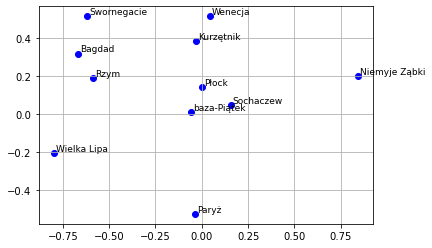

In [15]:
import random
from random import randrange, seed
from time import time
import numpy as np

seed(1234)


# =========================================================================== GENETIC ALGORITHM =======================================
# Class to represent problems to be solved by means of a general
# genetic algorithm. It includes the following attributes:
# - genes: list of possible genes(cities) in a chromosome
# - decode: tuple of names of successive genes(cities), zeroth element is base name
# - fitness: method that returns the evaluation of a chromosome (acts over the
#    genotype)
# - mutation: function that implements a mutation over a chromosome
# - crossover: function that implements the crossover operator over two chromosomes
# =====================================================================================================================================

class Problem_Genetic(object):

    def __init__(self, capacities, n_trucks, coord_bazy, coord_klienci, capacity_trucks, max_distance, decode, alpha, beta):
        self.genes = [(i+1, capacities[i]) for i in range(len(capacities))] + (n_trucks-1) * [('truck', capacity_trucks)]
        self.n_trucks = n_trucks
        self.coord_bazy = coord_bazy
        self.coord_klienci = coord_klienci
        self.capacity_trucks = capacity_trucks
        self.max_distance = max_distance
        self.decode = decode
        self.alpha = alpha
        self.beta = beta

    @staticmethod
    def mutation(chromosome, prob):
        chromosome_result = chromosome
        if random.random() < prob:
            index1 = randrange(0, len(chromosome)-1) 
            index2 = randrange(index1+1, len(chromosome))

            chromosome_mid = chromosome[index1:(index2+1)]
            chromosome_mid.reverse()
        
            chromosome_result = chromosome[0:index1] + chromosome_mid + chromosome[(index2+1):]
        return chromosome_result

    def crossover(self, parent1, parent2):

        def process_gen_repeated(copy_child1, copy_child2):
            cnt1 = 0
            for gen1 in copy_child1[:pos]:
                keys_child1 = [copy_child1[i][0] for i in range(len(copy_child1))]
                repeat1 = keys_child1.count(gen1[0]) 
                keys_child2 = [copy_child2[i][0] for i in range(len(copy_child2))]
                if gen1[0] != 'truck':
                    if repeat1 > 1: 
                        cnt2 = 0
                        for gen2 in copy_child2[pos:]:
                            if gen2[0] != 'truck':
                                if gen2 not in copy_child1[pos:]:
                                    copy_child1[cnt1] = copy_child2[pos+cnt2]
                                    copy_child2[pos+cnt2] = parent1[cnt1]
                                    break
                            else:
                                rep_truck = keys_child2.count('truck')
                                if rep_truck > self.n_trucks-1:
                                    copy_child1[cnt1] = copy_child2[pos+cnt2]
                                    copy_child2[pos+cnt2] = parent1[cnt1]
                                    break
                            cnt2 += 1
                else:
                    if repeat1 > self.n_trucks - 1: 
                        cnt2 = 0
                        for gen2 in copy_child2[pos:]:
                            if gen2[0] != 'truck':
                                if gen2 not in copy_child1[pos:]:
                                    copy_child1[cnt1] = copy_child2[pos+cnt2]
                                    copy_child2[pos+cnt2] = parent1[cnt1]
                                    break
                            cnt2 += 1
                cnt1 += 1
            return copy_child1, copy_child2

        pos = random.randrange(1, len(parent1)) 
        child1 = parent1[:pos] + parent2[pos:]
        child2 = parent2[:pos] + parent1[pos:]

        process_gen_repeated(child1, child2)
        return child1, child2


    def decodeVRP(self, chromosome):
        list = []
        cities = {i:self.decode[i] for i in range(len(self.decode))}
        for (k, v) in chromosome:
            if k == 'truck':
                list.append('truck')
                continue
            list.append(cities.get(k))
        return list

    def is_capacity_allowed(self, chromosome):
        load = 0
        for (k, v) in chromosome:
            if k != 'truck':
                load += v
            else:
                if load > self.capacity_trucks:
                    return False
                load = 0
        return True

    def trucks_distances(self, chromosome):
        dist_trucks = self.n_trucks *[0]
        idx = 0

        chromosome_base = [(0,123456789)] + chromosome + [(0,123456789)] 
        i = 0
        k = 0
        while i < 2*(self.n_trucks-1) + len(chromosome):
            if chromosome[k][0] == 'truck':
                chromosome_base.insert(i+1, (0,123456789))
                chromosome_base.insert(i+3, (0,123456789))
                i += 3
            else:
                i += 1
            k += 1

        distances = odleglosci(self.coord_bazy, self.coord_klienci)
        prev = 0
        for (k,v) in chromosome_base[1:]:
            if k != 'truck':
                dist_trucks[idx] += distances[prev, k]
                prev = k
            else:
                idx += 1
            
        return dist_trucks
        
    def is_distance_allowed(self, chromosome):
        dists = self.trucks_distances(chromosome)
        for i in range(len(dists)):
            if dists[i] > self.max_distance:
                return False
        return True

    def fitness(self, chromosome):

        fitness_value = 0 
        n_tr =  (sum(1 for i in range(len(chromosome) - 1) if chromosome[i][0] == 'truck' ) +1-sum(1 for i in range(len(chromosome) - 1) if chromosome[i][0]=='truck'  and chromosome[i+1][0] == 'truck'))
        if chromosome[0][0] == 'truck':
            n_tr -=1
        if chromosome[-1][0] == 'truck':
            n_tr -=1
        fitness_value = self.alpha*n_tr

        sum_distances = sum(self.trucks_distances(chromosome))
        fitness_value += self.beta * sum_distances
        return fitness_value
            

        


def odleglosci(coord_bazy, coord_klientow):
    liczba_klientow = len(coord_klientow)
    odleglosc = np.zeros((liczba_klientow + 1, liczba_klientow + 1), dtype=float)

    for i in range(liczba_klientow):
        odleglosc.itemset((0, i + 1), euclidean_dist(coord_bazy, coord_klientow[i]))
        odleglosc.itemset((i + 1, 0), odleglosc[0, i + 1])
        if i == 0:
            continue
        for j in range(i + 1, liczba_klientow + 1):
            odleglosc.itemset((i, j), euclidean_dist(coord_klientow[i - 1], coord_klientow[j - 1]))
            odleglosc.itemset((j, i), odleglosc[i, j])
    return odleglosc

def euclidean_dist(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)





# ========================================================== FIRST PART: GENETIC OPERATORS============================================
# Here We defined the requierements functions that the GA needs to work
# The function receives as input:
# * problem_genetic: an instance of the class Problem_Genetic, with
#     the optimization problem that we want to solve.
# * k: number of participants on the selection tournaments, WARNING: k<=size
# * opt: max or min, indicating if it is a maximization or a
#     minimization problem.
# * ngen: number of generations (halting condition)
# * size: number of individuals for each generation
# * ratio_cross: portion of the population which will be obtained by
#     means of crossovers.
# * prob_mutate: probability that a gene mutation will take place.
# =====================================================================================================================================


def genetic_algorithm_t(problem_genetic, k, opt, ngen, size, ratio_cross, prob_mutate):
    
    def initial_population(problem_genetic, size):
        return [random.sample(problem_genetic.genes, len(problem_genetic.genes)) 
                 for _ in range(size)]

     
    def new_generation_t(problem_genetic, k, opt, population, n_parents, n_directs, prob_mutate):

        def tournament_selection(problem_genetic, population, n, k, opt):
            winners = []
            for _ in range(n):
                elements = random.sample(population, k)
                winners.append(opt(elements, key=problem_genetic.fitness))
            return winners

        
        def cross_parents(problem_genetic, parents):
            childs = []
            for i in range(0, len(parents), 2):
                childs.extend(problem_genetic.crossover(parents[i], parents[i + 1]))
            return childs

       
        def mutate(population, prob):
            population_updated = len(population)*[0]
            iter = 0
            for chromosome in population:
                population_updated[iter] = Problem_Genetic.mutation(chromosome, prob)
                iter += 1
            return population_updated

        directs = tournament_selection(problem_genetic, population, n_directs, k, opt)
        crosses = cross_parents(problem_genetic, tournament_selection(problem_genetic, population, n_parents, k, opt))
        mutations = mutate(crosses, prob_mutate)
        new_generation = directs + mutations

        return new_generation

    population = initial_population(problem_genetic, size)
    n_parents = round(size * ratio_cross)
    n_parents = (n_parents if n_parents % 2 == 0 else n_parents - 1)
    n_directs = size - n_parents

    for iter in range(ngen):
        population = new_generation_t(problem_genetic, k, opt, population, n_parents, n_directs, prob_mutate)

    
    found = True
    bestChromosome = opt(population, key=problem_genetic.fitness)
    for i in range(len(population)):
        if not (problem_genetic.is_capacity_allowed(bestChromosome) and problem_genetic.is_distance_allowed(bestChromosome)):
            population = [ind for ind in population if ind != bestChromosome]
            bestChromosome = opt(population, key=problem_genetic.fitness)
        else:
            break
        
        if i == len(population)-1:
            found = False
            print('None of the chromosomes meet conditions.')
    if found:
        print("Chromosome: ", bestChromosome)
        genotype = problem_genetic.decodeVRP(bestChromosome)
        print("Solution: ", (genotype, problem_genetic.fitness(bestChromosome)))
        return (genotype, problem_genetic.fitness(bestChromosome))

# ------------------------------------------------------------------------

def VRP(capacities, n_trucks, coord_bazy, coord_klienci, capacity_trucks, max_distance, decode, alpha, beta, k):
    VRP_PROBLEM = Problem_Genetic(capacities, n_trucks, coord_bazy, coord_klienci, 
                                  capacity_trucks, max_distance, decode, alpha, beta)

    print(f"{30*'-'}Executing{30*'-'} \n")
    czasy = k * [0]
    for i in range(k):
        t_start = time()
        genetic_algorithm_t(VRP_PROBLEM, k=2, opt=min, ngen=2, size=1000, ratio_cross=0.4, prob_mutate=0.25)
        t_end = time()
        czasy[i] = t_end - t_start
        print(f"Time in {i}. iteration: ", czasy[i], " secs.\n")

    print("\n")
    print(f"Mean time: ", sum(czasy)/k, " secs.\n")


def scale_points(points):
    xs = [x for x, y in points]
    ys = [y for x, y in points]
    
    xmin, xmax = 16.14215, 23.22879
    ymin, ymax = 48.5, 55.58664
    
    scaled_points = []
    for x, y in points:
        x_norm = (x - xmin) / (xmax - xmin)
        y_norm = (y - ymin) / (ymax - ymin)
        
        x_scaled = x_norm * 2 - 1
        y_scaled = y_norm * 2 - 1
        
        scaled_points.append((x_scaled, y_scaled))
    
    return scaled_points


if __name__ == "__main__":
    num_trucks = 4
    max_dist = 1e10
    capacity_trucks = 1e10
    alpha = 0 
    beta = 1
    
    baza_nieprzeskalowane = np.array([[19.47960, 52.06882]])
    klienci_nieprzeskalowane = np.array([[20.23920, 52.21582], [19.68956,52.54133], [22.67707,52.74032], [19.57087, 53.40174], [17.61199, 52.71230], [19.84672, 53.85904], [19.55943, 50.18194], [17.49790, 53.85966], [16.85477, 51.32267], [17.31453, 53.16582]])
    punkty_nieprzeskalowane = np.concatenate((baza_nieprzeskalowane,klienci_nieprzeskalowane), axis=0)
    punkty = scale_points(punkty_nieprzeskalowane)
    baza = punkty[0]
    klienci = punkty[1:]
    labels = ('baza-Piątek', 'Sochaczew', 'Płock', 'Niemyje Ząbki', 'Kurzętnik', 'Rzym', 'Wenecja', 'Paryż', 'Swornegacie', 'Wielka Lipa', 'Bagdad')
    VRP_PROBLEM1 = Problem_Genetic(
        [20,8, 10, 60000, 10, 10,10, 10, 10, 10], num_trucks, baza, klienci, capacity_trucks, max_dist, 
        labels, alpha, beta)
    
    genetic_algorithm_t(VRP_PROBLEM1, k=10, opt=min, ngen=5, size=1000, ratio_cross=0.4, prob_mutate=0.1)



# RYSOWANIE PUNKTOW NA MAPIE
import matplotlib.pyplot as plt

x_coords = [p[0] for p in punkty]
y_coords = [p[1] for p in punkty]
plt.scatter(x_coords, y_coords, color='blue')

for i, label in enumerate(labels):
    plt.text(x_coords[i] + 0.01, y_coords[i] + 0.01, label, fontsize=9)

plt.grid(True)
plt.show()

# Testy parametrów dla symulowanego wyżarzania

### Graficzne porównania różnych metod schładzania

In [18]:
# to mamy zadane
np.random.seed(123)
n = 10
baza = np.array([0,0])
klienci = np.random.uniform(low = -1.0, high = 1.0, size = (n,2))
alpha = 1
beta = 3  
D = 10000
d = np.ones(shape=len(klienci))
capacity = 500
labels = ('baza', 'Miasto1', 'Miasto2','Miasto3','Miasto4','Miasto5','Miasto6','Miasto7','Miasto8','Miasto9','Miasto10')

In [19]:
baza_nieprzeskalowane = np.array([[19.47960, 52.06882]])
klienci_nieprzeskalowane = np.array([[20.23920, 52.21582], [19.68956,52.54133], [22.67707,52.74032], [19.57087, 53.40174], [17.61199, 52.71230], [19.84672, 53.85904], [19.55943, 50.18194], [17.49790, 53.85966], [16.85477, 51.32267], [17.31453, 53.16582]])
punkty_nieprzeskalowane = np.concatenate((baza_nieprzeskalowane,klienci_nieprzeskalowane), axis=0)
punkty = scale_points(punkty_nieprzeskalowane)
baza2 = punkty[0]
klienci2 = punkty[1:]
labels2 = ('baza-Piątek', 'Sochaczew', 'Płock', 'Niemyje Ząbki', 'Kurzętnik', 'Rzym', 'Wenecja', 'Paryż', 'Swornegacie', 'Wielka Lipa', 'Bagdad')

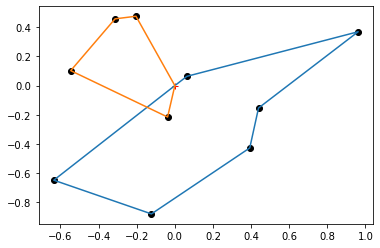

Koszt:  18.25606077078654


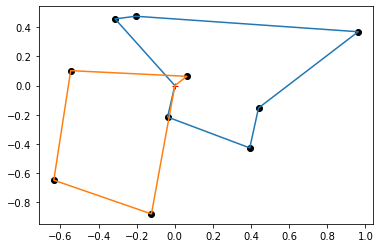

Koszt:  19.386036442420533


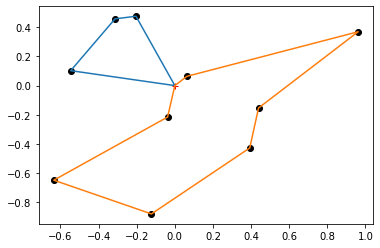

Koszt:  17.613213729489672


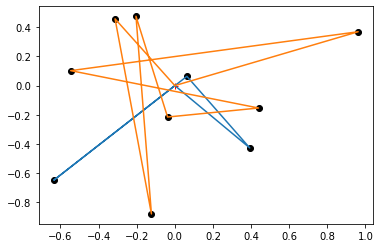

Koszt:  32.69558334162206


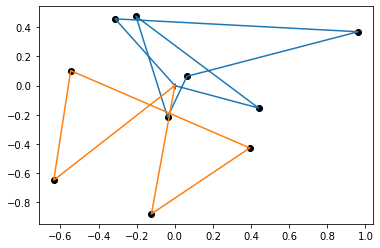

Koszt:  28.10349688743321


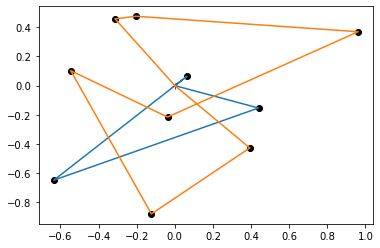

Koszt:  26.04932109358119


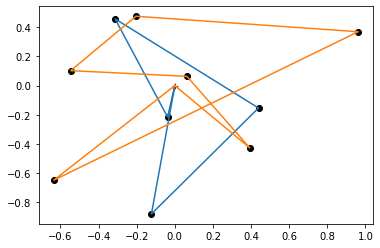

Koszt:  29.960928499928528


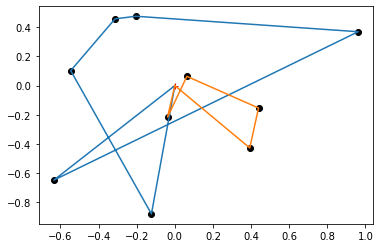

Koszt:  24.831266053960743


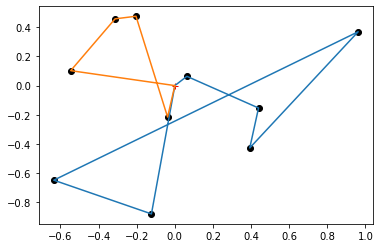

Koszt:  21.445212871042425


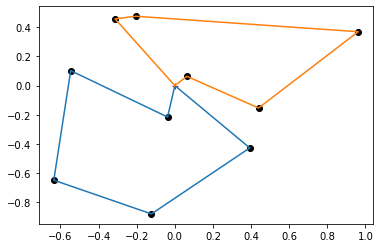

Koszt:  19.515525421034674


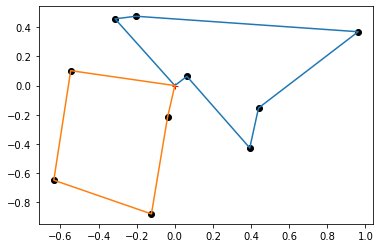

Koszt:  18.899253145422204


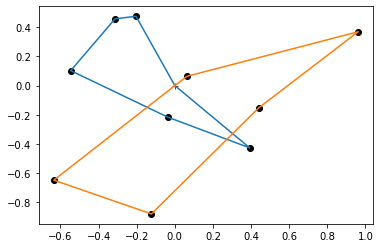

Koszt:  20.645658113914696


([array([2, 6, 8], dtype=int64),
  array([ 5,  9,  7,  1,  3,  4, 10], dtype=int64)],
 17.613213729489672)

In [18]:
sa_coolrate(1000, baza, klienci, 10000, d, capacity, D, alpha, beta)

### Wartość funkcji kary w zależności od temperatury poczatkowej i rodzaju schladzania (zbiór losowy)

In [62]:
def penalty_comparison(T_base_list, baza, klienci, num_iterations, d, capacity, D, alpha, beta):
    y_list = []
    for i in range(4):
        aux = []
        for T in T_base_list:
            mean = 0
            for j in range(3):
                x = simulated_annealing_step_2(2, baza, klienci, T, num_iterations, d, capacity, D, alpha, beta, i + 1)
                mean += x[1]
            aux.append(mean/3)
        y_list.append(aux)
    
    colors = itertools.cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'brown', 'magenta'])
    markers = itertools.cycle(['o', 's', '^', 'd', '*', 'v', '<', '>'])

   
    plt.figure(figsize=(10, 6))

    for idx, y in enumerate(y_list):
        color = next(colors)
        marker = next(markers)
        if idx == 0:
            plt.plot(T_base_list, y, label=f'Typ schładzania: geometryczne', color=color, marker=marker)
        elif idx == 1:
            plt.plot(T_base_list, y, label=f'Typ schładzania: logarytmiczne', color=color, marker=marker)
        elif idx == 2:
            plt.plot(T_base_list, y, label=f'Typ schładzania: liniowe', color=color, marker=marker)
        else:
            plt.plot(T_base_list, y, label=f'Typ schładzania: harmoniczne', color=color, marker=marker)
            
    plt.xscale('log')
    plt.xlabel('Temperatura początkowa')
    plt.ylabel('Wartości funkcji kary')
    plt.title('Wykres uśrednionej zależności wartości funkcji kary od rodzaju schładzania i tempreratury początkowej')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

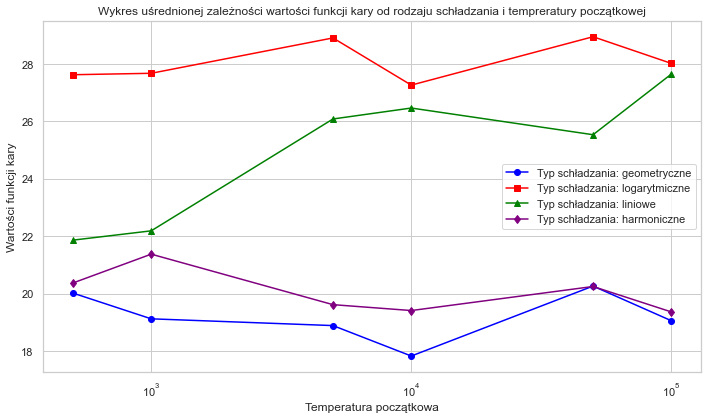

In [63]:
penalty_comparison([500, 1000, 5000, 10000, 50000, 100000], baza, klienci, 10000, d, capacity, D, alpha, beta)

### Wartość funkcji kary w zależności od temperatury poczatkowej i rodzaju schladzania (punkty z mapy Polski)

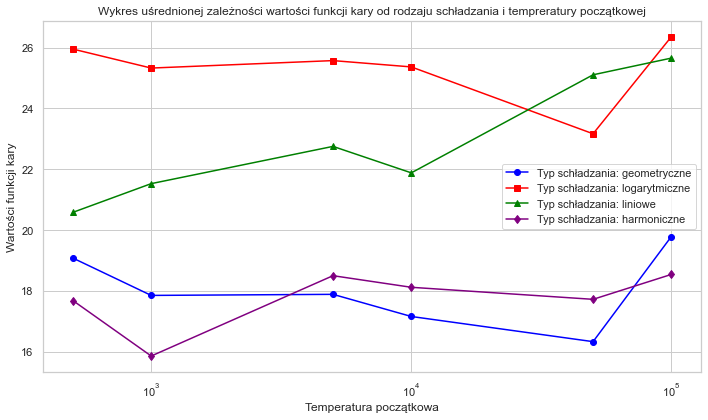

In [64]:
penalty_comparison([500, 1000, 5000, 10000, 50000, 100000], baza2, klienci2, 10000, d, capacity, D, alpha, beta)

# Testy parametrów dla algorytmu genetycznego

In [22]:
VRP_PROBLEM1 = Problem_Genetic(
        d, 2, baza, klienci, capacity, D, 
        labels, alpha, beta)
    
genetic_algorithm_t(VRP_PROBLEM1, k=10, opt=min, ngen=10, size=1000, ratio_cross=0.4, prob_mutate=0.1)

Chromosome:  [(5, 1.0), (9, 1.0), (7, 1.0), (1, 1.0), (3, 1.0), (4, 1.0), (8, 1.0), (6, 1.0), (2, 1.0), (10, 1.0), ('truck', 500)]
Solution:  (['Miasto5', 'Miasto9', 'Miasto7', 'Miasto1', 'Miasto3', 'Miasto4', 'Miasto8', 'Miasto6', 'Miasto2', 'Miasto10', 'truck'], 16.88761497739432)


(['Miasto5',
  'Miasto9',
  'Miasto7',
  'Miasto1',
  'Miasto3',
  'Miasto4',
  'Miasto8',
  'Miasto6',
  'Miasto2',
  'Miasto10',
  'truck'],
 16.88761497739432)

### Testowanie size

In [50]:
def size_comparison(d, num_trucks, baza, klienci, capacity, D, 
        labels, alpha, beta, k, ngen, size_list, ratio_cross, prob_mutate):
    y_list = []
    for size in size_list:
        mean = 0
        for j in range(3):
            VRP_PROBLEM1 = Problem_Genetic(
            d, num_trucks, baza, klienci, capacity, D, 
            labels, alpha, beta)
            a, b = genetic_algorithm_t(VRP_PROBLEM1, k=10, opt=min, ngen=10, size=size, ratio_cross=0.4, prob_mutate=0.1)
            mean += b
        y_list.append(mean/3)

    plt.figure(figsize=(10, 6))
    plt.plot(size_list, y_list, color='blue', marker='o')
    plt.xscale('log')
    plt.xlabel('Wielkość początkowa')
    plt.ylabel('Wartości funkcji kary')
    plt.title('Wykres zależności wartości funkcji kary od początkowej wielkości populacji')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Chromosome:  [(4, 1.0), (1, 1.0), (2, 1.0), (9, 1.0), (8, 1.0), (6, 1.0), (10, 1.0), (7, 1.0), (3, 1.0), (5, 1.0), ('truck', 500)]
Solution:  (['Miasto4', 'Miasto1', 'Miasto2', 'Miasto9', 'Miasto8', 'Miasto6', 'Miasto10', 'Miasto7', 'Miasto3', 'Miasto5', 'truck'], 24.8634890730391)
Chromosome:  [(4, 1.0), (1, 1.0), ('truck', 500), (8, 1.0), (10, 1.0), (3, 1.0), (7, 1.0), (5, 1.0), (9, 1.0), (2, 1.0), (6, 1.0)]
Solution:  (['Miasto4', 'Miasto1', 'truck', 'Miasto8', 'Miasto10', 'Miasto3', 'Miasto7', 'Miasto5', 'Miasto9', 'Miasto2', 'Miasto6'], 26.291112639355497)
Chromosome:  [(8, 1.0), (4, 1.0), (10, 1.0), (3, 1.0), (1, 1.0), (5, 1.0), (2, 1.0), (6, 1.0), ('truck', 500), (9, 1.0), (7, 1.0)]
Solution:  (['Miasto8', 'Miasto4', 'Miasto10', 'Miasto3', 'Miasto1', 'Miasto5', 'Miasto2', 'Miasto6', 'truck', 'Miasto9', 'Miasto7'], 25.30564409449953)
Chromosome:  [(5, 1.0), (3, 1.0), (1, 1.0), (7, 1.0), (9, 1.0), (2, 1.0), (8, 1.0), (6, 1.0), (4, 1.0), (10, 1.0), ('truck', 500)]
Solution:  (['Mia

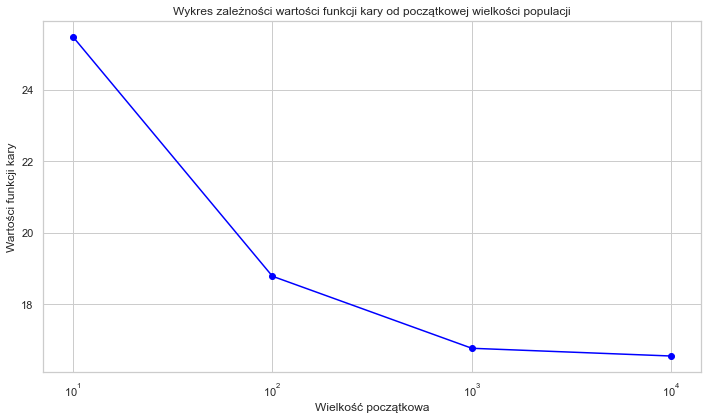

In [51]:
size_comparison(d, 2, baza, klienci, capacity, D, labels, alpha, beta, 10, 10, [10, 100, 1000, 10000], 0.4, 0.1)

Chromosome:  [(10, 1.0), ('truck', 500), (1, 1.0), (3, 1.0), (7, 1.0), (9, 1.0), (8, 1.0), (4, 1.0), (6, 1.0), (2, 1.0), (5, 1.0)]
Solution:  (['Bagdad', 'truck', 'Sochaczew', 'Niemyje Ząbki', 'Paryż', 'Wielka Lipa', 'Swornegacie', 'Kurzętnik', 'Wenecja', 'Płock', 'Rzym'], 23.80260521830899)
Chromosome:  [('truck', 500), (6, 1.0), (2, 1.0), (10, 1.0), (9, 1.0), (7, 1.0), (1, 1.0), (3, 1.0), (8, 1.0), (5, 1.0), (4, 1.0)]
Solution:  (['truck', 'Wenecja', 'Płock', 'Bagdad', 'Wielka Lipa', 'Paryż', 'Sochaczew', 'Niemyje Ząbki', 'Swornegacie', 'Rzym', 'Kurzętnik'], 22.122466718044524)
Chromosome:  [(2, 1.0), (1, 1.0), (3, 1.0), (4, 1.0), (6, 1.0), (9, 1.0), (8, 1.0), (5, 1.0), (10, 1.0), (7, 1.0), ('truck', 500)]
Solution:  (['Płock', 'Sochaczew', 'Niemyje Ząbki', 'Kurzętnik', 'Wenecja', 'Wielka Lipa', 'Swornegacie', 'Rzym', 'Bagdad', 'Paryż', 'truck'], 17.963668307154812)
Chromosome:  [(1, 1.0), (4, 1.0), (6, 1.0), (3, 1.0), (10, 1.0), (8, 1.0), (5, 1.0), (9, 1.0), (7, 1.0), (2, 1.0), ('tr

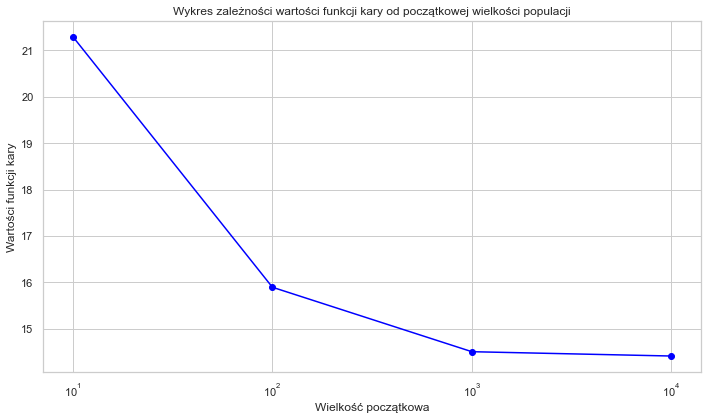

In [52]:
size_comparison(d, 2, baza2, klienci2, capacity, D, labels2, alpha, beta, 10, 10, [10, 100, 1000, 10000], 0.4, 0.1)

#### Ze względu na zasoby obliczeniowe użyjemy size = 100

### Testowanie k 

In [53]:
def draw_size_comparison(d, num_trucks, baza, klienci, capacity, D, 
        labels, alpha, beta, k_list, ngen, size, ratio_cross, prob_mutate):
    y_list = []
    for draw_size in k_list:
        mean = 0
        for j in range(3):
            VRP_PROBLEM1 = Problem_Genetic(
            d, num_trucks, baza, klienci, capacity, D, 
            labels, alpha, beta)
            a, b = genetic_algorithm_t(VRP_PROBLEM1, k=draw_size, opt=min, ngen=10, size=100, ratio_cross=0.4, prob_mutate=0.1)
            mean += b
        y_list.append(mean/3)

    plt.figure(figsize=(10, 6))
    plt.plot(k_list, y_list, color='blue', marker='o')
    plt.xlabel('Wielkości podzbiorów')
    plt.ylabel('Wartości funkcji kary')
    plt.title('Wykres zależności wartości funkcji kary od wielkości podzbiorów turniejowych')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Chromosome:  [(8, 1.0), (6, 1.0), (2, 1.0), (9, 1.0), (7, 1.0), (3, 1.0), (4, 1.0), (1, 1.0), (10, 1.0), (5, 1.0), ('truck', 500)]
Solution:  (['Miasto8', 'Miasto6', 'Miasto2', 'Miasto9', 'Miasto7', 'Miasto3', 'Miasto4', 'Miasto1', 'Miasto10', 'Miasto5', 'truck'], 18.355917192853468)
Chromosome:  [('truck', 500), (5, 1.0), (3, 1.0), (1, 1.0), (7, 1.0), (9, 1.0), (2, 1.0), (8, 1.0), (6, 1.0), (4, 1.0), (10, 1.0)]
Solution:  (['truck', 'Miasto5', 'Miasto3', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto2', 'Miasto8', 'Miasto6', 'Miasto4', 'Miasto10'], 18.754432934957453)
Chromosome:  [(10, 1.0), (3, 1.0), (1, 1.0), (4, 1.0), (8, 1.0), (6, 1.0), (2, 1.0), (9, 1.0), (7, 1.0), (5, 1.0), ('truck', 500)]
Solution:  (['Miasto10', 'Miasto3', 'Miasto1', 'Miasto4', 'Miasto8', 'Miasto6', 'Miasto2', 'Miasto9', 'Miasto7', 'Miasto5', 'truck'], 17.086874571138264)
Chromosome:  [(10, 1.0), (1, 1.0), (7, 1.0), (9, 1.0), (5, 1.0), (3, 1.0), (4, 1.0), (8, 1.0), (6, 1.0), (2, 1.0), ('truck', 500)]
Solution:  (['

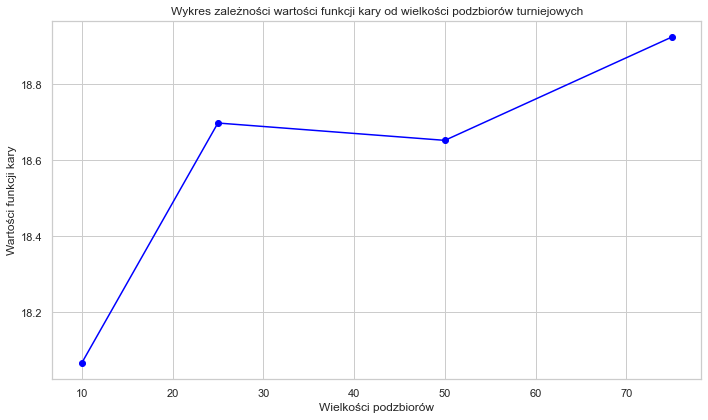

In [54]:
draw_size_comparison(d, 2, baza, klienci, capacity, D, labels, alpha, beta, [10, 25, 50, 75], 10, 100, 0.4, 0.1)

Chromosome:  [(8, 1.0), (10, 1.0), (5, 1.0), (4, 1.0), (6, 1.0), (3, 1.0), (1, 1.0), (2, 1.0), (9, 1.0), (7, 1.0), ('truck', 500)]
Solution:  (['Swornegacie', 'Bagdad', 'Rzym', 'Kurzętnik', 'Wenecja', 'Niemyje Ząbki', 'Sochaczew', 'Płock', 'Wielka Lipa', 'Paryż', 'truck'], 17.464307350572813)
Chromosome:  [('truck', 500), (7, 1.0), (5, 1.0), (8, 1.0), (10, 1.0), (9, 1.0), (4, 1.0), (6, 1.0), (3, 1.0), (1, 1.0), (2, 1.0)]
Solution:  (['truck', 'Paryż', 'Rzym', 'Swornegacie', 'Bagdad', 'Wielka Lipa', 'Kurzętnik', 'Wenecja', 'Niemyje Ząbki', 'Sochaczew', 'Płock'], 17.509387639499522)
Chromosome:  [(9, 1.0), (10, 1.0), (5, 1.0), (8, 1.0), (7, 1.0), (1, 1.0), (3, 1.0), (6, 1.0), (4, 1.0), (2, 1.0), ('truck', 500)]
Solution:  (['Wielka Lipa', 'Bagdad', 'Rzym', 'Swornegacie', 'Paryż', 'Sochaczew', 'Niemyje Ząbki', 'Wenecja', 'Kurzętnik', 'Płock', 'truck'], 17.052784939856764)
Chromosome:  [(7, 1.0), (9, 1.0), (5, 1.0), (8, 1.0), (10, 1.0), (6, 1.0), (4, 1.0), (2, 1.0), (3, 1.0), (1, 1.0), ('t

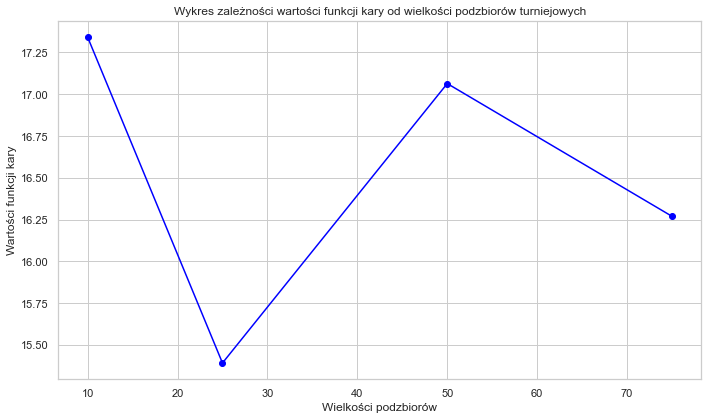

In [55]:
draw_size_comparison(d, 2, baza2, klienci2, capacity, D, labels2, alpha, beta, [10, 25, 50 ,75], 10, 100, 0.4, 0.1)

#### Przyjmiemy k = 10 (szybciej się wykona)

### Testowanie ratio_cross

In [56]:
def ratio_cross_comparison(d, num_trucks, baza, klienci, capacity, D, 
        labels, alpha, beta, k, ngen, size, ratio_cross_list, prob_mutate):
    y_list = []
    for ratio_cross in ratio_cross_list:
        mean = 0 
        for j in range(3):
        
            VRP_PROBLEM1 = Problem_Genetic(
            d, num_trucks, baza, klienci, capacity, D, 
            labels, alpha, beta)
            a, b = genetic_algorithm_t(VRP_PROBLEM1, k=10, opt=min, ngen=10, size=100, ratio_cross=ratio_cross, prob_mutate=0.1)
            mean += b
        y_list.append(mean/3)

    
    plt.figure(figsize=(10, 6))
    plt.plot(ratio_cross_list, y_list, color='red', marker='d')
    plt.xlabel('Wartość ratio_cross')
    plt.ylabel('Wartości funkcji kary')
    plt.title('Wykres zależności wartości funkcji kary od wartości ratio_cross')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Chromosome:  [(8, 1.0), (6, 1.0), (2, 1.0), (5, 1.0), (10, 1.0), (9, 1.0), (7, 1.0), (1, 1.0), (3, 1.0), (4, 1.0), ('truck', 500)]
Solution:  (['Miasto8', 'Miasto6', 'Miasto2', 'Miasto5', 'Miasto10', 'Miasto9', 'Miasto7', 'Miasto1', 'Miasto3', 'Miasto4', 'truck'], 18.733401826018735)
Chromosome:  [(8, 1.0), (6, 1.0), (2, 1.0), (1, 1.0), (7, 1.0), (9, 1.0), (5, 1.0), (3, 1.0), (4, 1.0), (10, 1.0), ('truck', 500)]
Solution:  (['Miasto8', 'Miasto6', 'Miasto2', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto5', 'Miasto3', 'Miasto4', 'Miasto10', 'truck'], 19.13414516444599)
Chromosome:  [('truck', 500), (4, 1.0), (3, 1.0), (1, 1.0), (5, 1.0), (2, 1.0), (9, 1.0), (7, 1.0), (8, 1.0), (6, 1.0), (10, 1.0)]
Solution:  (['truck', 'Miasto4', 'Miasto3', 'Miasto1', 'Miasto5', 'Miasto2', 'Miasto9', 'Miasto7', 'Miasto8', 'Miasto6', 'Miasto10'], 20.655825243118507)
Chromosome:  [(7, 1.0), (9, 1.0), (2, 1.0), (5, 1.0), (3, 1.0), (1, 1.0), (4, 1.0), (8, 1.0), (6, 1.0), (10, 1.0), ('truck', 500)]
Solution:  (['M

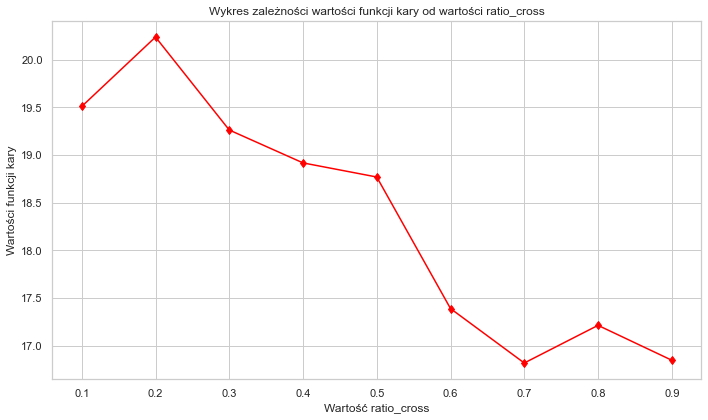

In [57]:
ratio_cross_comparison(d, 2, baza, klienci, capacity, D, labels, alpha, beta, 10, 10, 100, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 0.1)

Chromosome:  [(10, 1.0), (9, 1.0), (5, 1.0), (8, 1.0), (2, 1.0), (3, 1.0), (1, 1.0), (4, 1.0), (6, 1.0), (7, 1.0), ('truck', 500)]
Solution:  (['Bagdad', 'Wielka Lipa', 'Rzym', 'Swornegacie', 'Płock', 'Niemyje Ząbki', 'Sochaczew', 'Kurzętnik', 'Wenecja', 'Paryż', 'truck'], 19.11759291161276)
Chromosome:  [(1, 1.0), (3, 1.0), (6, 1.0), (7, 1.0), (5, 1.0), (9, 1.0), (10, 1.0), (8, 1.0), (4, 1.0), (2, 1.0), ('truck', 500)]
Solution:  (['Sochaczew', 'Niemyje Ząbki', 'Wenecja', 'Paryż', 'Rzym', 'Wielka Lipa', 'Bagdad', 'Swornegacie', 'Kurzętnik', 'Płock', 'truck'], 17.69566653647661)
Chromosome:  [(2, 1.0), (6, 1.0), (4, 1.0), (1, 1.0), (3, 1.0), (7, 1.0), (5, 1.0), (8, 1.0), (10, 1.0), (9, 1.0), ('truck', 500)]
Solution:  (['Płock', 'Wenecja', 'Kurzętnik', 'Sochaczew', 'Niemyje Ząbki', 'Paryż', 'Rzym', 'Swornegacie', 'Bagdad', 'Wielka Lipa', 'truck'], 16.89788885728955)
Chromosome:  [('truck', 500), (7, 1.0), (1, 1.0), (3, 1.0), (6, 1.0), (8, 1.0), (10, 1.0), (5, 1.0), (9, 1.0), (4, 1.0), 

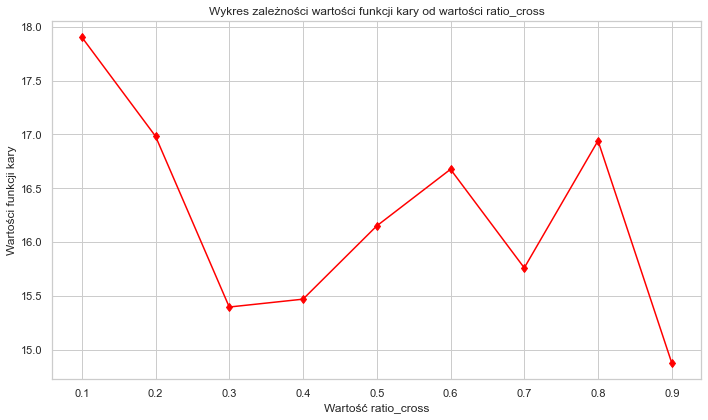

In [58]:
ratio_cross_comparison(d, 2, baza2, klienci2, capacity, D, labels2, alpha, beta, 10, 10, 100, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 0.1)

#### Przyjmiemy cross_val = 0.9

In [59]:
def prob_comparison(d, num_trucks, baza, klienci, capacity, D, 
        labels, alpha, beta, k, ngen, size, ratio_cross_list, prob_mutate_list):
    y_list = []
    for prob_mutate in prob_mutate_list:
        mean = 0 
        for j in range(3):
            VRP_PROBLEM1 = Problem_Genetic(
            d, num_trucks, baza, klienci, capacity, D, 
            labels, alpha, beta)
            a, b = genetic_algorithm_t(VRP_PROBLEM1, k=10, opt=min, ngen=10, size=100, ratio_cross=0.8, prob_mutate=prob_mutate)
            mean += b
        y_list.append(mean/3)

    plt.figure(figsize=(10, 6))
    plt.plot(prob_mutate_list, y_list, color='green', marker='+')
    plt.xlabel('Wartość prob_mutate')
    plt.ylabel('Wartości funkcji kary')
    plt.title('Wykres zależności wartości funkcji kary od wartości prob_mutate')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Chromosome:  [(5, 1.0), (9, 1.0), (7, 1.0), (3, 1.0), (1, 1.0), (4, 1.0), (10, 1.0), (8, 1.0), (6, 1.0), (2, 1.0), ('truck', 500)]
Solution:  (['Miasto5', 'Miasto9', 'Miasto7', 'Miasto3', 'Miasto1', 'Miasto4', 'Miasto10', 'Miasto8', 'Miasto6', 'Miasto2', 'truck'], 18.680289662787015)
Chromosome:  [(10, 1.0), (4, 1.0), (3, 1.0), (1, 1.0), (7, 1.0), (9, 1.0), (6, 1.0), (8, 1.0), (2, 1.0), (5, 1.0), ('truck', 500)]
Solution:  (['Miasto10', 'Miasto4', 'Miasto3', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto6', 'Miasto8', 'Miasto2', 'Miasto5', 'truck'], 17.68231341900223)
Chromosome:  [(3, 1.0), (1, 1.0), (7, 1.0), (9, 1.0), (5, 1.0), (2, 1.0), (6, 1.0), (8, 1.0), (4, 1.0), (10, 1.0), ('truck', 500)]
Solution:  (['Miasto3', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto5', 'Miasto2', 'Miasto6', 'Miasto8', 'Miasto4', 'Miasto10', 'truck'], 18.221000900940275)
Chromosome:  [(10, 1.0), (8, 1.0), (6, 1.0), (2, 1.0), (9, 1.0), (7, 1.0), (5, 1.0), (1, 1.0), (3, 1.0), (4, 1.0), ('truck', 500)]
Solution:  (['M

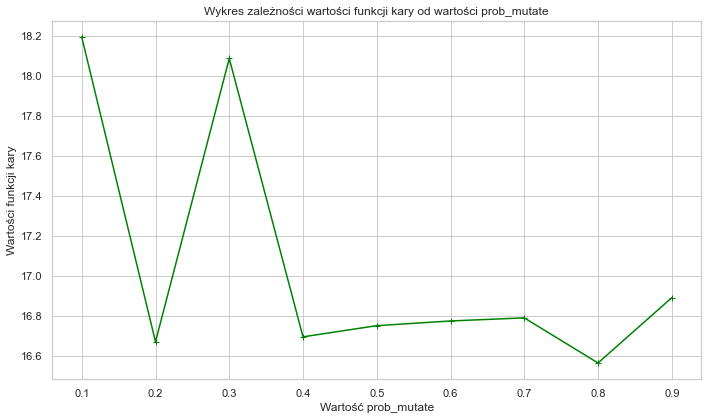

In [60]:
prob_comparison(d, 2, baza, klienci, capacity, D, labels, alpha, beta, 10, 10, 100, 0.9, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Chromosome:  [(2, 1.0), (1, 1.0), (3, 1.0), (7, 1.0), (9, 1.0), (5, 1.0), (8, 1.0), (10, 1.0), (6, 1.0), (4, 1.0), ('truck', 500)]
Solution:  (['Płock', 'Sochaczew', 'Niemyje Ząbki', 'Paryż', 'Wielka Lipa', 'Rzym', 'Swornegacie', 'Bagdad', 'Wenecja', 'Kurzętnik', 'truck'], 15.71963384296673)
Chromosome:  [(2, 1.0), (5, 1.0), (8, 1.0), (10, 1.0), (9, 1.0), (7, 1.0), (3, 1.0), (6, 1.0), (4, 1.0), (1, 1.0), ('truck', 500)]
Solution:  (['Płock', 'Rzym', 'Swornegacie', 'Bagdad', 'Wielka Lipa', 'Paryż', 'Niemyje Ząbki', 'Wenecja', 'Kurzętnik', 'Sochaczew', 'truck'], 16.131287671609215)
Chromosome:  [(1, 1.0), (2, 1.0), (4, 1.0), (6, 1.0), (3, 1.0), (7, 1.0), (9, 1.0), (5, 1.0), (10, 1.0), (8, 1.0), ('truck', 500)]
Solution:  (['Sochaczew', 'Płock', 'Kurzętnik', 'Wenecja', 'Niemyje Ząbki', 'Paryż', 'Wielka Lipa', 'Rzym', 'Bagdad', 'Swornegacie', 'truck'], 15.528207062628889)
Chromosome:  [(4, 1.0), (6, 1.0), (8, 1.0), (10, 1.0), (9, 1.0), (5, 1.0), (7, 1.0), (3, 1.0), (1, 1.0), (2, 1.0), ('tr

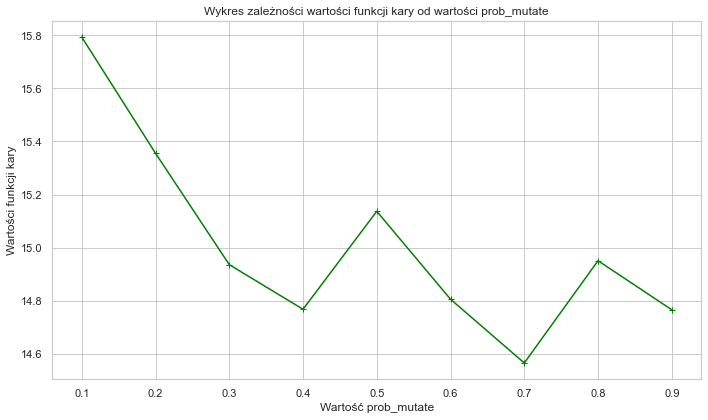

In [61]:
prob_comparison(d, 2, baza2, klienci2, capacity, D, labels2, alpha, beta, 10, 10, 100, 0.9, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

### Wybieramy prob_mutate = 0.8

## Porównanie algorytmów

In [16]:
def porownanie_na_zbiorze(baza, klienci, labels):
    czasy_ag = 30 * [0]
    kara_ag = 30 * [0]
    VRP_PROBLEM1 = Problem_Genetic(
        d, num_trucks, baza, klienci, capacity, D, 
        labels, alpha, beta)
    for i in range(30):
        t_start = time()
        a, b = genetic_algorithm_t(VRP_PROBLEM1, k=10, opt=min, ngen=10, size=100, ratio_cross=0.9, prob_mutate=0.8)
        t_end = time()
        kara_ag[i] = b
        czasy_ag[i] = t_end - t_start
    czasy_sw = 30 * [0]
    kara_sw = 30 * [0]
    for i in range(30):
        t_start = time()
        obecne, obecny_koszt, baza, klienci = simulated_annealing_step_2(2, baza, klienci, 10000, 5000, d, capacity, D, alpha, beta, 1)
        t_end = time()
        kara_sw[i] = obecny_koszt
        czasy_sw[i] = t_end - t_start
        
    df = pd.DataFrame({
        'Penalty': kara_ag + kara_sw,
        'Time': czasy_ag + czasy_sw,
        'Algorithm': ['AG'] * len(kara_ag) + ['SW'] * len(kara_sw)
    })
    
    # Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Algorithm', y='Penalty', data=df)
    plt.title('Porównanie wartości funkcji kary')
    plt.ylabel('Wartość funkcji kary')
    plt.xlabel('Algorytm')
    plt.show()
    
    # Scatter plot czas vs jakość
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Time', y='Penalty', hue='Algorithm', data=df, s=100)
    plt.title('Zależność między czasem a jakością')
    plt.xlabel('Czas wykonania [s]')
    plt.ylabel('Wartość funkcji kary')
    plt.legend(title='Algorytm')
    plt.show()
    
    return czasy_ag, kara_ag, czasy_sw, kara_sw

Chromosome:  [('truck', 500), ('truck', 500), (5, 1.0), (7, 1.0), (9, 1.0), (2, 1.0), (6, 1.0), (8, 1.0), (4, 1.0), (3, 1.0), (1, 1.0), (10, 1.0), ('truck', 500)]
Solution:  (['truck', 'truck', 'Miasto5', 'Miasto7', 'Miasto9', 'Miasto2', 'Miasto6', 'Miasto8', 'Miasto4', 'Miasto3', 'Miasto1', 'Miasto10', 'truck'], 16.840654945991325)
Chromosome:  [('truck', 500), (5, 1.0), (3, 1.0), (4, 1.0), (1, 1.0), (7, 1.0), (9, 1.0), (2, 1.0), (8, 1.0), (6, 1.0), (10, 1.0), ('truck', 500), ('truck', 500)]
Solution:  (['truck', 'Miasto5', 'Miasto3', 'Miasto4', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto2', 'Miasto8', 'Miasto6', 'Miasto10', 'truck', 'truck'], 17.032471611664274)
Chromosome:  [('truck', 500), (10, 1.0), (4, 1.0), (3, 1.0), (1, 1.0), (7, 1.0), (9, 1.0), (2, 1.0), (6, 1.0), (8, 1.0), (5, 1.0), ('truck', 500), ('truck', 500)]
Solution:  (['truck', 'Miasto10', 'Miasto4', 'Miasto3', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto2', 'Miasto6', 'Miasto8', 'Miasto5', 'truck', 'truck'], 16.584244053721

Chromosome:  [(10, 1.0), (8, 1.0), (6, 1.0), (2, 1.0), (9, 1.0), (7, 1.0), (1, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), ('truck', 500), ('truck', 500), ('truck', 500)]
Solution:  (['Miasto10', 'Miasto8', 'Miasto6', 'Miasto2', 'Miasto9', 'Miasto7', 'Miasto1', 'Miasto3', 'Miasto4', 'Miasto5', 'truck', 'truck', 'truck'], 16.55202140114026)
Chromosome:  [('truck', 500), ('truck', 500), (1, 1.0), (3, 1.0), (4, 1.0), (10, 1.0), (8, 1.0), (6, 1.0), (2, 1.0), (9, 1.0), (7, 1.0), (5, 1.0), ('truck', 500)]
Solution:  (['truck', 'truck', 'Miasto1', 'Miasto3', 'Miasto4', 'Miasto10', 'Miasto8', 'Miasto6', 'Miasto2', 'Miasto9', 'Miasto7', 'Miasto5', 'truck'], 17.348971029195727)
Chromosome:  [('truck', 500), (4, 1.0), (3, 1.0), (1, 1.0), (7, 1.0), (9, 1.0), (2, 1.0), (6, 1.0), (8, 1.0), (10, 1.0), (5, 1.0), ('truck', 500), ('truck', 500)]
Solution:  (['truck', 'Miasto4', 'Miasto3', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto2', 'Miasto6', 'Miasto8', 'Miasto10', 'Miasto5', 'truck', 'truck'], 16.7897171963318

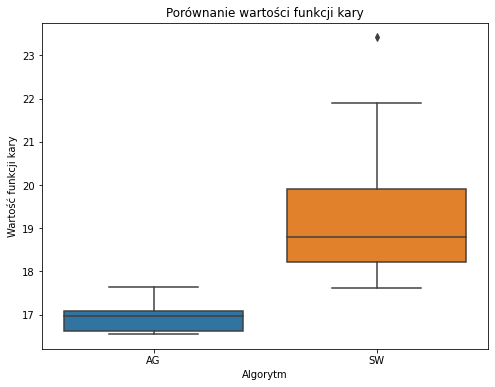

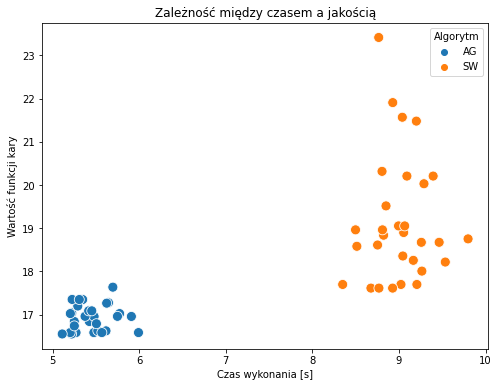

In [20]:
czasy_ag, kara_ag, czasy_sw, kara_sw = porownanie_na_zbiorze(baza, klienci, labels)

Chromosome:  [(2, 1.0), (1, 1.0), (3, 1.0), (6, 1.0), (4, 1.0), (8, 1.0), (10, 1.0), (5, 1.0), (9, 1.0), (7, 1.0), ('truck', 500), ('truck', 500), ('truck', 500)]
Solution:  (['Płock', 'Sochaczew', 'Niemyje Ząbki', 'Wenecja', 'Kurzętnik', 'Swornegacie', 'Bagdad', 'Rzym', 'Wielka Lipa', 'Paryż', 'truck', 'truck', 'truck'], 14.407212742907127)
Chromosome:  [(7, 1.0), (1, 1.0), (3, 1.0), (6, 1.0), (4, 1.0), (8, 1.0), (10, 1.0), (9, 1.0), (5, 1.0), (2, 1.0), ('truck', 500), ('truck', 500), ('truck', 500)]
Solution:  (['Paryż', 'Sochaczew', 'Niemyje Ząbki', 'Wenecja', 'Kurzętnik', 'Swornegacie', 'Bagdad', 'Wielka Lipa', 'Rzym', 'Płock', 'truck', 'truck', 'truck'], 16.1108243272788)
Chromosome:  [('truck', 500), (7, 1.0), (9, 1.0), (5, 1.0), (10, 1.0), (8, 1.0), (6, 1.0), (4, 1.0), (3, 1.0), (1, 1.0), (2, 1.0), ('truck', 500), ('truck', 500)]
Solution:  (['truck', 'Paryż', 'Wielka Lipa', 'Rzym', 'Bagdad', 'Swornegacie', 'Wenecja', 'Kurzętnik', 'Niemyje Ząbki', 'Sochaczew', 'Płock', 'truck', 

Chromosome:  [('truck', 500), ('truck', 500), (2, 1.0), (4, 1.0), (6, 1.0), (8, 1.0), (10, 1.0), (5, 1.0), (9, 1.0), (7, 1.0), (3, 1.0), (1, 1.0), ('truck', 500)]
Solution:  (['truck', 'truck', 'Płock', 'Kurzętnik', 'Wenecja', 'Swornegacie', 'Bagdad', 'Rzym', 'Wielka Lipa', 'Paryż', 'Niemyje Ząbki', 'Sochaczew', 'truck'], 14.68688895376076)
Chromosome:  [('truck', 500), ('truck', 500), (7, 1.0), (9, 1.0), (5, 1.0), (10, 1.0), (8, 1.0), (6, 1.0), (4, 1.0), (2, 1.0), (3, 1.0), (1, 1.0), ('truck', 500)]
Solution:  (['truck', 'truck', 'Paryż', 'Wielka Lipa', 'Rzym', 'Bagdad', 'Swornegacie', 'Wenecja', 'Kurzętnik', 'Płock', 'Niemyje Ząbki', 'Sochaczew', 'truck'], 14.968533621290984)
Chromosome:  [('truck', 500), ('truck', 500), (1, 1.0), (3, 1.0), (6, 1.0), (4, 1.0), (8, 1.0), (10, 1.0), (5, 1.0), (9, 1.0), (7, 1.0), (2, 1.0), ('truck', 500)]
Solution:  (['truck', 'truck', 'Sochaczew', 'Niemyje Ząbki', 'Wenecja', 'Kurzętnik', 'Swornegacie', 'Bagdad', 'Rzym', 'Wielka Lipa', 'Paryż', 'Płock',

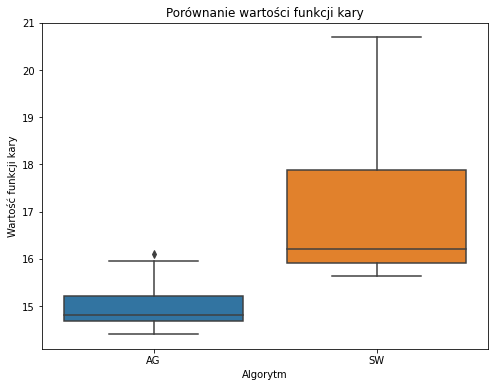

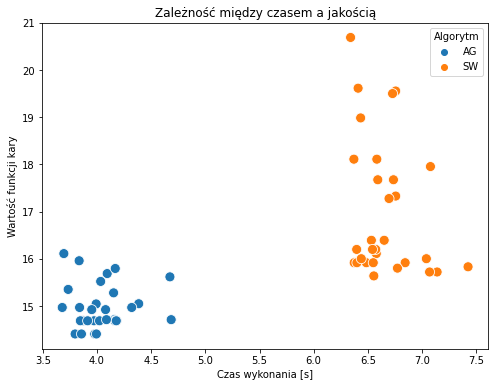

In [21]:
czasy_ag2, kara_ag2, czasy_sw2, kara_sw2 = porownanie_na_zbiorze(baza2, klienci2, labels2)

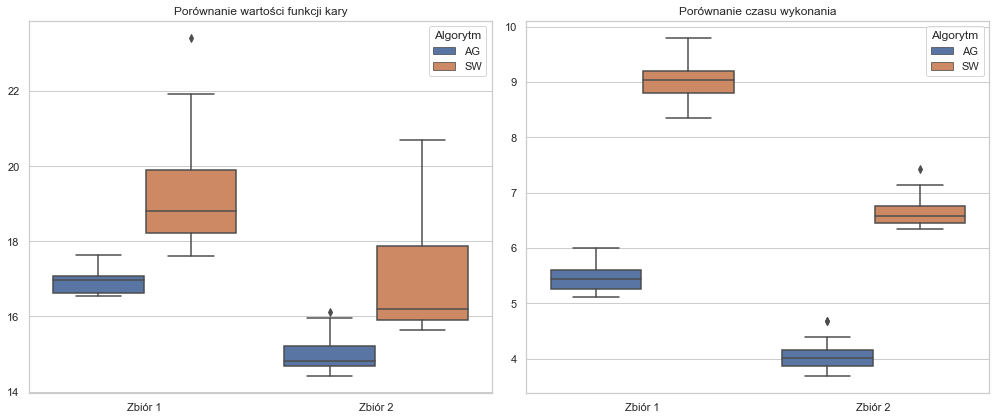

In [22]:
data = {
    'Algorytm': (['AG'] * len(czasy_ag) + ['SW'] * len(czasy_sw) +
                 ['AG'] * len(czasy_ag2) + ['SW'] * len(czasy_sw2)),
    'Czas': czasy_ag + czasy_sw + czasy_ag2 + czasy_sw2,
    'Kara': kara_ag + kara_sw + kara_ag2 + kara_sw2,
    'Zbiór danych': (['Zbiór 1'] * (len(czasy_ag) + len(czasy_sw)) +
                     ['Zbiór 2'] * (len(czasy_ag2) + len(czasy_sw2)))
}

df = pd.DataFrame(data)


sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot dla funkcji kary
sns.boxplot(x="Zbiór danych", y="Kara", hue="Algorytm", data=df, ax=axes[0])
axes[0].set_title("Porównanie wartości funkcji kary")

# Boxplot dla czasu wykonania
sns.boxplot(x="Zbiór danych", y="Czas", hue="Algorytm", data=df, ax=axes[1])
axes[1].set_title("Porównanie czasu wykonania")

for ax in axes:
    ax.legend(title="Algorytm")
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
plt.show()

# Szybkość zbieżności

In [23]:
def simulated_annealing_step_2_listakosztow(ust_pojazd, baza, klienci, T, num_iterations, d, capacity, D, alpha, beta, cool_rate):
    '''
    Funkcja działa tak samo jak simulated_annealing_step_2, 
    ale zapisujemy i zwracamy wartości funkcji kary osiągnięte w kolejnych iteracjach
    ''' 
    
    obecne = stworz_wektor_pojazdy(len(klienci), ust_pojazd)
    cr3 = T/num_iterations
    kontrolny_id = 0
    kara_lista = []
    while not sprawdz_ladownosc(obecne, d, capacity):
        obecne = stworz_wektor_pojazdy(len(klienci), ust_pojazd)
        kontrolny_id += 1
        if kontrolny_id > 500:
            print('Niemożliwe znalezienie kombinacji spełniającej warunki.')
            return 
    
    obecne = potasuj(obecne, ust_pojazd)
    kontrolny_id = 0
    while not sprawdz_odleglosci(obecne, D, baza, klienci):
        obecne = potasuj(obecne, ust_pojazd)
        kontrolny_id += 1
        if kontrolny_id > 500:
            print('Niemożliwe znalezienie kombinacji spełniającej warunki.')
            return 
    
    kontrolny_id = 0
    for j in range(num_iterations):
        
        if random.randint(0,1):
            nowe_propozycja = reorder(obecne)
        else:
            nowe_propozycja = swap(obecne, klienci)
        if sprawdz_ladownosc(nowe_propozycja, d, capacity) and sprawdz_odleglosci(nowe_propozycja, D, baza, klienci):
            nowe = nowe_propozycja
            obecny_koszt = kara(obecne, baza, klienci, alpha, beta)
            kara_lista.append(obecny_koszt)
            nowy_koszt = kara(nowe, baza, klienci, alpha, beta)
            if nowy_koszt < obecny_koszt or (nowy_koszt != obecny_koszt and \
                            np.exp(-(nowy_koszt - obecny_koszt)/(T+1e-10)) > np.random.uniform(0, 1, size = 1)[0]):
                obecne = nowe
        else:
            kontrolny_id += 1
            if kontrolny_id > num_iterations/2:
                break
        if cool_rate == 1: # sprawdzamy jaki mamy rodzaj cool_rate
            T = T * 0.95
        elif cool_rate == 2:
            T = (np.log(2 + j)/np.log(3 + j)) * T
        elif cool_rate == 3:
            T = T - cr3
        elif cool_rate == 4:
            T = (1/(j+1)) * T

    return (obecne, obecny_koszt, baza, klienci, kara_lista)

In [31]:
def genetic_algorithm_t_listakosztow(problem_genetic, k, opt, ngen, size, ratio_cross, prob_mutate):
    '''
    Funkcja działa tak samo jak genetic_algorithm_t, ale zapisujemy i zwracamy wartości 
    funkcji kosztów osiągane w kolejnych pokoleniach.
    '''
    kara_lista = []
    
    def initial_population(problem_genetic, size):
        return [random.sample(problem_genetic.genes, len(problem_genetic.genes)) 
                 for _ in range(size)]

     
    def new_generation_t(problem_genetic, k, opt, population, n_parents, n_directs, prob_mutate):

        def tournament_selection(problem_genetic, population, n, k, opt):
            winners = []
            for _ in range(n):
                elements = random.sample(population, k)
                winners.append(opt(elements, key=problem_genetic.fitness))
            return winners

        
        def cross_parents(problem_genetic, parents):
            childs = []
            for i in range(0, len(parents), 2):
                childs.extend(problem_genetic.crossover(parents[i], parents[i + 1]))
            return childs

       
        def mutate(population, prob):
            population_updated = len(population)*[0]
            iter = 0
            for chromosome in population:
                population_updated[iter] = Problem_Genetic.mutation(chromosome, prob)
                iter += 1
            return population_updated

        directs = tournament_selection(problem_genetic, population, n_directs, k, opt)
        crosses = cross_parents(problem_genetic, tournament_selection(problem_genetic, population, n_parents, k, opt))
        mutations = mutate(crosses, prob_mutate)
        new_generation = directs + mutations

        return new_generation

    population = initial_population(problem_genetic, size)
    n_parents = round(size * ratio_cross)
    n_parents = (n_parents if n_parents % 2 == 0 else n_parents - 1)
    n_directs = size - n_parents

    for iter in range(ngen):
        population = new_generation_t(problem_genetic, k, opt, population, n_parents, n_directs, prob_mutate)
        found_in_gen = True
        best_in_gen = opt(population, key=problem_genetic.fitness)
        for i in range(len(population)):
            if not (problem_genetic.is_capacity_allowed(best_in_gen) and problem_genetic.is_distance_allowed(best_in_gen)):
                population = [ind for ind in population if ind != best_in_gen]
                best_in_gen = opt(population, key=problem_genetic.fitness)
            else:
                kara_lista.append(problem_genetic.fitness(best_in_gen))
                break
        
            if i == len(population)-1:
                found = False
                kara_lista.append(None)

    
    found = True
    bestChromosome = opt(population, key=problem_genetic.fitness)
    for i in range(len(population)):
        if not (problem_genetic.is_capacity_allowed(bestChromosome) and problem_genetic.is_distance_allowed(bestChromosome)):
            population = [ind for ind in population if ind != bestChromosome]
            bestChromosome = opt(population, key=problem_genetic.fitness)
        else:
            break
        
        if i == len(population)-1:
            found = False
            print('None of the chromosomes meet conditions.')
    if found:
        genotype = problem_genetic.decodeVRP(bestChromosome)
        print("Solution: ", (genotype, problem_genetic.fitness(bestChromosome)))
        return (genotype, problem_genetic.fitness(bestChromosome), kara_lista)


In [33]:
def szybkosc_zb_wiele_wykonan(baza, klienci, labels):
    lista_uruchomien_sw = []
    lista_uruchomien_ag = [] 
    VRP_PROBLEM1 = Problem_Genetic(
        d, num_trucks, baza, klienci, capacity, D, 
        labels, alpha, beta)
    for i in range(10):
        _, _, _, _, kara_lista_sw = simulated_annealing_step_2_listakosztow(2, baza, klienci, 10000, 5000, d, capacity, D, alpha, beta, 1)
        _, _, kara_lista_ag = genetic_algorithm_t_listakosztow(VRP_PROBLEM1, k=10, opt=min, ngen=10, size=100, ratio_cross=0.9, prob_mutate=0.8)
        lista_uruchomien_sw.append(kara_lista_sw)
        lista_uruchomien_ag.append(kara_lista_ag)
    
    sw_arr = np.array(lista_uruchomien_sw) 
    ag_arr = np.array(lista_uruchomien_ag) 
    
    sw_mean = np.mean(sw_arr, axis=0)
    sw_q25 = np.percentile(sw_arr, 25, axis=0)
    sw_q75 = np.percentile(sw_arr, 75, axis=0)
    
    ag_mean = np.mean(ag_arr, axis=0)
    ag_q25 = np.percentile(ag_arr, 25, axis=0)
    ag_q75 = np.percentile(ag_arr, 75, axis=0)
    
    
    sw_x = np.arange(1, len(sw_mean) + 1)
    ag_x = np.arange(1, len(ag_mean) + 1)
    
    # Wykres
    fig, ax_sw = plt.subplots(figsize=(14, 6))
    
    # Symulowane wyżarzanie
    ax_sw.plot(sw_x, sw_mean, color='blue', label="SW – średnia")
    ax_sw.fill_between(sw_x, sw_q25, sw_q75, color='blue', alpha=0.2, label="SW – 25–75 percentyl")
    ax_sw.set_xlabel("Iteracje (Symulowane Wyżarzanie)", color='blue')
    ax_sw.set_ylabel("Wartość funkcji kary")
    ax_sw.tick_params(axis='x', colors='blue')
    
    # Algorytm genetyczny
    ax_ag = ax_sw.twiny()
    ax_ag.plot(ag_x, ag_mean, color='green', label="AG – średnia")
    ax_ag.fill_between(ag_x, ag_q25, ag_q75, color='green', alpha=0.2, label="AG – 25–75 percentyl")
    ax_ag.set_xlabel("Pokolenia (Algorytm Genetyczny)", color='green')
    ax_ag.xaxis.set_label_position('top')
    ax_ag.xaxis.tick_top()
    ax_ag.tick_params(axis='x', colors='green')
    
    # Legenda
    lines = ax_sw.get_lines() + ax_ag.get_lines()
    labels_plot = [line.get_label() for line in lines]
    ax_sw.legend(lines, labels_plot, loc='upper right')
    
    plt.title("Wartości funkcji kary z kwartylami w zależności od numeru pokolenia lub iteracji")
    ax_sw.grid(True)
    plt.tight_layout()
    plt.show()

Solution:  (['truck', 'Miasto5', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto2', 'Miasto6', 'Miasto8', 'Miasto4', 'Miasto3', 'Miasto10', 'truck', 'truck'], 17.02413290221966)
Solution:  (['truck', 'Miasto5', 'Miasto9', 'Miasto7', 'Miasto1', 'Miasto3', 'Miasto4', 'Miasto8', 'Miasto6', 'Miasto2', 'Miasto10', 'truck', 'truck'], 16.88761497739432)
Solution:  (['truck', 'Miasto2', 'Miasto6', 'Miasto8', 'Miasto10', 'Miasto3', 'Miasto4', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto5', 'truck', 'truck'], 17.824554550230143)
Solution:  (['truck', 'truck', 'Miasto8', 'Miasto6', 'Miasto2', 'Miasto9', 'Miasto7', 'Miasto1', 'Miasto4', 'Miasto3', 'Miasto10', 'Miasto5', 'truck'], 17.186398034461504)
Solution:  (['truck', 'Miasto10', 'Miasto3', 'Miasto4', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto5', 'Miasto8', 'Miasto6', 'Miasto2', 'truck', 'truck'], 18.09642780326398)
Solution:  (['truck', 'Miasto4', 'Miasto3', 'Miasto1', 'Miasto7', 'Miasto9', 'Miasto2', 'Miasto6', 'Miasto8', 'Miasto10', 'Miasto5', 'truck', '

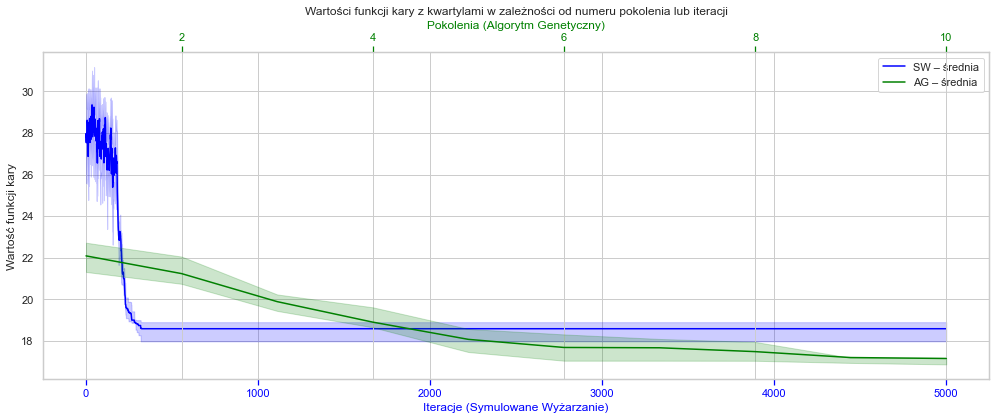

In [34]:
szybkosc_zb_wiele_wykonan(baza, klienci, labels)

Solution:  (['truck', 'truck', 'Płock', 'Paryż', 'Rzym', 'Wielka Lipa', 'Bagdad', 'Swornegacie', 'Kurzętnik', 'Wenecja', 'Niemyje Ząbki', 'Sochaczew', 'truck'], 16.29034797293415)
Solution:  (['truck', 'Płock', 'Sochaczew', 'Niemyje Ząbki', 'Wenecja', 'Kurzętnik', 'Swornegacie', 'Bagdad', 'Rzym', 'Wielka Lipa', 'Paryż', 'truck', 'truck'], 14.407212742907127)
Solution:  (['truck', 'truck', 'Płock', 'Sochaczew', 'Niemyje Ząbki', 'Wenecja', 'Kurzętnik', 'Swornegacie', 'Bagdad', 'Rzym', 'Wielka Lipa', 'Paryż', 'truck'], 14.407212742907127)
Solution:  (['Paryż', 'Wielka Lipa', 'Rzym', 'Bagdad', 'Swornegacie', 'Kurzętnik', 'Wenecja', 'Niemyje Ząbki', 'Sochaczew', 'Płock', 'truck', 'truck', 'truck'], 14.407212742907127)
Solution:  (['truck', 'truck', 'Paryż', 'Wielka Lipa', 'Rzym', 'Bagdad', 'Swornegacie', 'Wenecja', 'Kurzętnik', 'Niemyje Ząbki', 'Sochaczew', 'Płock', 'truck'], 14.710566090878917)
Solution:  (['Płock', 'Niemyje Ząbki', 'Wenecja', 'Kurzętnik', 'Swornegacie', 'Bagdad', 'Rzym', 

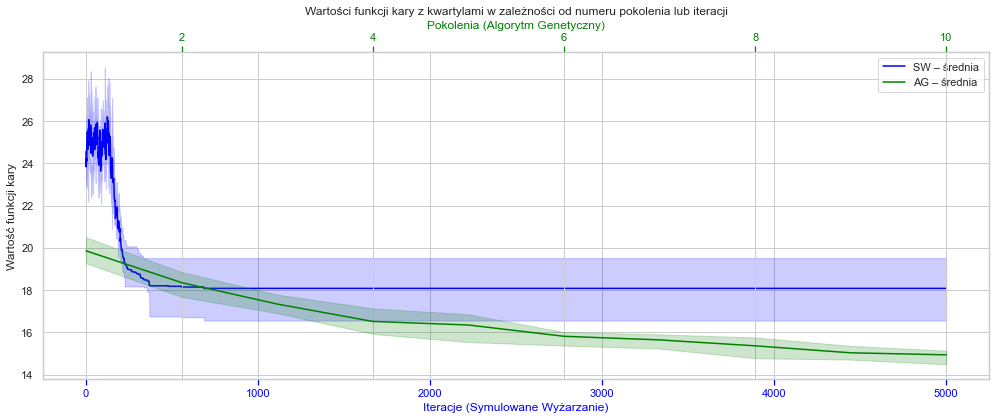

In [35]:
szybkosc_zb_wiele_wykonan(baza2, klienci2, labels2)